<img src="https://pages.cnpem.br/workshopbioimagens/wp-content/uploads/sites/166/2023/06/logo-ilum-2048x382.png" alt="Descrição da imagem" style="width: 1000px; height: auto; ">


<div style=" padding: 10px; font-size: 37px; text-align: center;">
<strong>Redes Neurais Convolucionais (CNN) 📸: </strong> 
<div style=" padding: 10px; font-size: 30px; text-align: center;">
<strong>E se os dados forem imagens?</strong> 

<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Autores:</strong> Maria Emily Nayla Gomes da Silva e Yasmin Barbosa Shimizu
<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Professor:</strong> Daniel R. Cassar

<div style="background-color: lightblue; font-size: 16px; padding: 10px;">
<div style="text-align: justify"><strong>Objetivo:</strong> Criar uma Rede Neural Convulucional utilizando <em>Pytorch Lightning</em> e teriná-las com dados de imagens de um dataset <em>MNIST</em>.</div>

# 📝 Introdução

<p align="justify"> 
  Redes neurais convolucionais (CNN, do inglês <i>Convolutional Neural Networks</i>) são algoritmos de <i>deep learning</i> que reconhecem padrões específicos que caracterizam e distinguem classes em imagens. São compostas, seguindo a estrutura padrão de redes neurais artificiais, por uma camada de entrada, uma camada de saída, e camadas ocultas de processamento, diferenciando-se nas últimas, as quais são compostas pela combinação de camadas convolucionais e de <i>pooling</i>. [3]</p>
<div style="text-align: justify">     
  As camadas convolucionais de uma CNN são caracterizadas por aplicar filtros na imagem, realçando regiões e traços característicos para a classificação. Já a camada de <i>pooling</i> reduz a dimensão da imagem, condensando as informações de vários pixel da região -- o <i>MaxPooling</i>, por exemplo, utiliza apenas o valor de maior píxel em blocos 2x2. Em geral, camadas convolucionais e de <i>pooling</i> são construídas em sequência, até que a matriz, após os processamentos anteriores, apresente apenas um ou poucos pixels que serão combinados e efetivamente associados a uma das classes. [3]</div> </p>
<div style="text-align: justify">     
  Este trabalho apresenta a construção de uma CNN utilizando dados do <i>dataset</i> <code>MNIST</code> importado do <code>PyTorch</code>, o qual contém inúmeros tensores de imagens em preto e branco, acompanhados de seus respectivos rótulos (<i>labels</i>) representando os dígitos. Partindo do código de referência feito por Nicola [1], foram realizadas modificações para torná-lo compatível com a biblioteca <code>Lightning</code>, permitindo a obtenção de um modelo otimizado para a identificação de números manuscritos. Para avaliar a qualidade do modelo, também foi gerada uma matriz de confusão.
</p>

In [1]:
import lightning as L
import torch
from torch import nn
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from typing import Optional
from torch.nn.functional import softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🎲 Dataset - MNIST

<div style="text-align: justify"> 
O dataset escolhido para desenvolver uma CNN com a biblioteca Lightning foi o MNIST. Esse conjunto de dados apresenta um extenso banco com 60.000 exemplos para treinamento, além de 10.000 exemplos previamente separados para teste. Dessa forma, trata-se de um conjunto vantajoso tanto para o treinamento quanto para a avaliação da performance do modelo treinado. A tabela a seguir descreve as informações disponíveis no dataset e o que buscamos prever. No caso de uma <em>Rede Neural Convolucional</em>, nosso objetivo é identificar padrões visuais nos dados de entrada (imagens) e classificá-los corretamente, encontrando suas labels.

</div>

<p> </p>

#### Tabela de Informações do Dataset MNIST

|| Dados    | Descrição                                                                                                     |
|----------|----------|---------------------------------------------------------------------------------------------------|
| *Feature* | Imagem | Matrizes representadas como tensores, que contêm os pixels das imagens em tons de cinza (28x28).             |
| *Target* | *Label*  | Rótulos correspondentes às imagens, variando de 0 a 9, representando os dígitos manuscritos (target da rede). |


#### Os dados como figura
<p> </p>
<div style="text-align: justify"> 
A seguir, apresenta-se uma imagem com 24 exemplos disponíveis, cada um composto por um tensor da imagem e seu respectivo rótulo, que representa o número correspondente.</p>

<div align="center">
  <img src="https://github.com/MEmilyGomes/CNN-Lightning-MNIST/blob/main/Imagens/24Imagens_MNIST.png?raw=true" alt="Descrição da imagem" width="1000"/>
</div>

<div style="text-align: justify"> Na célula abaixo, definimos a classe <code>DataModule</code>, a qual é responsável pelo tratamento dos dados utilizados em nossa rede neural -- tanto o download de dados, como sua conversão de imagens para tensores e divisão em <i>sets</i> de treino, teste e validação. Esta classe foi baseada na classe <code>Dataset</code> construída por Nicola [1], alterando a forma como o <i>split</i> treino e validação é definido -- agora pelo <code>sci-kit learn</code>, como visto em aula, e não pelo <code>PyTorch</code>, definindo o tamanho do conjunto de validação e a semente aleatória fora da classe.

In [2]:
TAMANHO_VALIDACAO = 1/6 # 1/6 do dataset de treino, ou seja, 10.000 imagens
SEMENTE_ALEATORIA = 1923024

class DataModule(L.LightningDataModule):

    def __init__(self, data_path: str = './'):
        super().__init__() #inicializa com atributos já existentes no Lightning
        
        #determina o diretório
        self.data_path = data_path
        
        # determina a "normalização" dos dados - aqui, serão apenas convertidos em tensores
        self.transform = transforms.Compose(
            [transforms.ToTensor()]
        )

    def prepare_data(self): # download dos dados no diretório pré-determinado
        MNIST(root=self.data_path, download=True)

    def setup(self, stage: Optional[str] = None) -> None:
        # tratamento e split em treino, teste e validação
        # stage: pode ser string ou None
        # não retorna nenhum objeto
        
#        if stage == "train":
        # CONJUNTOS DE TREINO E VALIDAÇÃO
        mnist_all = MNIST(
            root=self.data_path,
            train=True, #seleciona os dados de treino do dataset
            transform=self.transform, #aplica  transformador - transforma de imagem para tensor
            download=False
        )

        N = len(mnist_all) # número de dados de treino

        #determina os conjuntos de treino e validação com um split
        self.train, self.val = train_test_split(
            mnist_all, 
            test_size=TAMANHO_VALIDACAO, 
            random_state= SEMENTE_ALEATORIA #salva o split para possibilitar a reprodução
        )
            
#        if stage == "test":
        # CONJUNTO DE TESTE
        self.test = MNIST(
            root=self.data_path,
            train=False, # selesciona os dados de teste (não treino) do dataset
            transform=self.transform, #aplica  transformador - transforma de imagem para tensor
            download=False
        )

    def train_dataloader(self): #carrega os dados de treino
        return DataLoader(self.train, batch_size=64, num_workers=4)

    def val_dataloader(self): #carrega os dados de validação
        return DataLoader(self.val, batch_size=64, num_workers=4)

    def test_dataloader(self): #carreha os dados de teste
        return DataLoader(self.test, batch_size=64, num_workers=4)


# 🏋️‍♀️ Construindo e Treinando uma CNN

<div style="text-align: justify"> Para a contrução da rede, foi usado como base o código desenvolvido por Nicola [1]. As alterações feitas estão relacionadas à biblioteca <code>Lightning</code>, que passou por atualizações nos últimos anos, deixando-a um pouco mais independente do <code>Pytorch</code>. Além disso, criamos os atributos <code>.y_true</code> e <code>.y_pred</code>, que salva as <i>labels</i> reais e previstas, respectivamente, para possibilitar o plot de uma matriz de confusão com os resultados. Também excluímos a função <code>main</code> para treinar e testar a rede manualmente, como feito em aula, e definimos a taxa de aprendizado fora da classe. Por fim, todo o código foi comentado para melhor entendimento da estrutura da CNN.

In [3]:
TAXA_DE_APRENDIZADO = 0.001

class CNN(L.LightningModule):

    def __init__(
            self,
            cnn_out_channels=None, #filtros ou canais de saída
            n_lables: int = 10 # 10 classes predeterminadas no MNIST (cada um dos 10 algarismos)
    ):
        super().__init__() #inicializa com atributos já existentes no Lightning

        if cnn_out_channels is None:
            cnn_out_channels = [16, 32, 64] #determina o número padrão de filtros em cada camada
            
        #acurácia em cada etapa
        self.train_acc = Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = Accuracy(task="multiclass", num_classes=10)
        self.test_acc = Accuracy(task="multiclass", num_classes=10)

        in_channels = 1 #número de entradas por imagem - começa com ela inteira

        cnn_block = list() # lista para armazenar cada camada
        for out_channel in cnn_out_channels: #para cada camada
            cnn_block.append(
                nn.Conv2d( # camada convolucional
                    in_channels=in_channels, #entrada
                    out_channels=out_channel, # filtros aplicados
                    kernel_size=3,
                    stride=1,
                    padding=1
                )
            )
            cnn_block.append(nn.ReLU()) #função de ativação
            cnn_block.append(nn.MaxPool2d((2, 2))) # camada de pooling - reduz as dimensões
            in_channels = out_channel # para a próxima camada, a entrada será p número de filtros aplicados

        self.cnn_block = nn.Sequential(*cnn_block) # agrupa todas as camadas em sequência
        
        #camada final
        self.head = nn.Sequential(
            nn.Flatten(), #transforma os dados num vetor 1D
            nn.Linear(cnn_out_channels[-1] * 3 * 3, n_lables) # transforma os dados do vetor em problabilidades para cada uma das 10 classes
        )
        
        #listas para salvar as labels na etapa de teste - serão usadas para visualização dos resultados
        self.y_true = []
        self.y_pred = []

    def forward(self, x): # passa os dados pela rede
        # é pré-determinado como __call__ do pytorch
        x = self.cnn_block(x)
        return self.head(x)

    # Para cada época, definimos as etapas:
    
    def training_step(self, batch, batch_idx): #etapa de treino em lotes
        x, y = batch #separa atributo e target
        logits = self(x) #forward
        loss = nn.functional.cross_entropy(logits, y) #calcula cross.entropy como erro entre o vetor saída da rede (logits) e as labels (y)
        preds = torch.argmax(logits, dim=1) # previsão de classes: a que tem maior probabilidade
        self.train_acc.update(preds, y) #atualiza o valor da acurácia da classificação
        self.log("train_loss", loss, prog_bar=True) #mostra erro no terminal
        return loss #retorna o erro

    def on_training_epoch_end(self): #camada final de treinamento de uma época
        self.log("train_acc", self.train_acc.compute()) #cálcula a acurácia total da época
        self.train_acc.reset() #reseta a acurácia para a próxima época

    def validation_step(self, batch, batch_idx): #etapa de validação em lotes: avalia se o modelo está aprendendo ou não a cada época
        x, y = batch #separa atributo e target
        logits = self(x) #forward
        loss = nn.functional.cross_entropy(logits, y) #calcula cross.entropy como erro entre o vetor saída da rede (logits) e as labels (y)
        preds = torch.argmax(logits, dim=1) # previsão de classes: a que tem maior probabilidade
        self.valid_acc.update(preds, y) #atualiza o valor da acurácia da classificação
        self.log("valid_loss", loss, prog_bar=True) #mostra erro no terminal
        return loss #retorna o erro

    def on_validation_epoch_end(self): #camada final de validação de uma época
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True) #cálcula a acurácia total da época
        self.valid_acc.reset() #reseta a acurácia para a próxima época

    def test_step(self, batch, batch_idx): #etapa de treino em lotes:
        x, y = batch  #separa atributo e target
        #sava os dados caso se deseje visualizá-los depois
        self.x_test_data = x #atributos 
        self.y_test_data = y #target
        logits = self(x) #forward
        loss = nn.functional.cross_entropy(logits, y) #calcula cross.entropy como erro entre o vetor saída da rede (logits) e as labels (y)
        self.preds = torch.argmax(logits, dim=1)  # previsão de classes: a que tem maior probabilidade
        self.test_acc.update(self.preds, y) #atualiza o valor da acurácia da classificação
        self.log("test_loss", loss, prog_bar=True)  #mostra erro no terminal
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)  #mostra acurácia no terminal
        
        self.y_true.extend(y.tolist()) #salva as labels reais
        self.y_pred.extend(self.preds.tolist()) #salva as labels previstas
        
        return loss #retorna o erro

    def configure_optimizers(self): #calcula e altera os gradientes para todos os parâmetros treináveis da rede, de acordo com a  taxa de aprendizado
        optimizer = torch.optim.Adam(self.parameters(), lr=TAXA_DE_APRENDIZADO)
        return optimizer

<div style="text-align: justify"> Para o treinamento da rede, primeiro determinamos um <code>treinador</code> para nossa rede baseado no número de épocas, e criamos instâncias das classes <code>DataModule</code> e <code>CNN</code>. Como o objetivo aqui é apenas testar a funcionalidade da rede construída, o treinamento será feito em poucas épocas, com <code>NUM_EPOCAS = 5</code>.

In [4]:
NUM_EPOCAS = 5

treinador = L.Trainer(max_epochs=NUM_EPOCAS) #determina o treinamento pelo número de épocas

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\venv\ilumpy\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
dm = DataModule() #carrega e trata os dados
minha_cnn = CNN() #determina uma instância da classe CNN - determina a rede neural

Assim, podemos, efetivamente, treinar a rede.

In [6]:
treinador.fit(minha_cnn, dm) #treina a rede automaticamente com os dados de treino e validação, passando pelas etapas de treino e validaçõa a cada época


  | Name      | Type               | Params
-------------------------------------------------
0 | train_acc | MulticlassAccuracy | 0     
1 | valid_acc | MulticlassAccuracy | 0     
2 | test_acc  | MulticlassAccuracy | 0     
3 | cnn_block | Sequential         | 23.3 K
4 | head      | Sequential         | 5.8 K 
-------------------------------------------------
29.1 K    Trainable params
0         Non-trainable params
29.1 K    Total params
0.116     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


Tendo o concluído o treinamento, mudamos as instâncias da rede e do dataset <code>minha_cnn</code> e <code>dm</code> para o estágio de teste, aplicando o <code>treinador</code> no modo de previsão e salvando o erro e acurácia obtidos.

In [7]:
minha_cnn.eval() #encerra o treino e determina o teste

CNN(
  (train_acc): MulticlassAccuracy()
  (valid_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (cnn_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=10, bias=True)
  )
)

In [8]:
dm.setup("test") #carrega e trata os dados de teste

In [9]:
resultado = treinador.test(minha_cnn, dm) #faz a etapa de teste, salva as métricas como dicionários

loss = resultado[0]['test_loss'] #resgata erro
acc = resultado[0]['test_acc'] #resgaata a acurácia


print(f"A previsão obteve acurácia de {round(acc*100, 2)}%")

c:\venv\ilumpy\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9831547141075134
        test_loss          0.042273689061403275
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
A previsão obteve acurácia de 98.32%


Por fim, resgatamos os atributos <code>minha_cnn.y_true</code> e <code>minha_cnn.y_pred</code> para exibição visual dos resultados através de uma matriz de confusão.

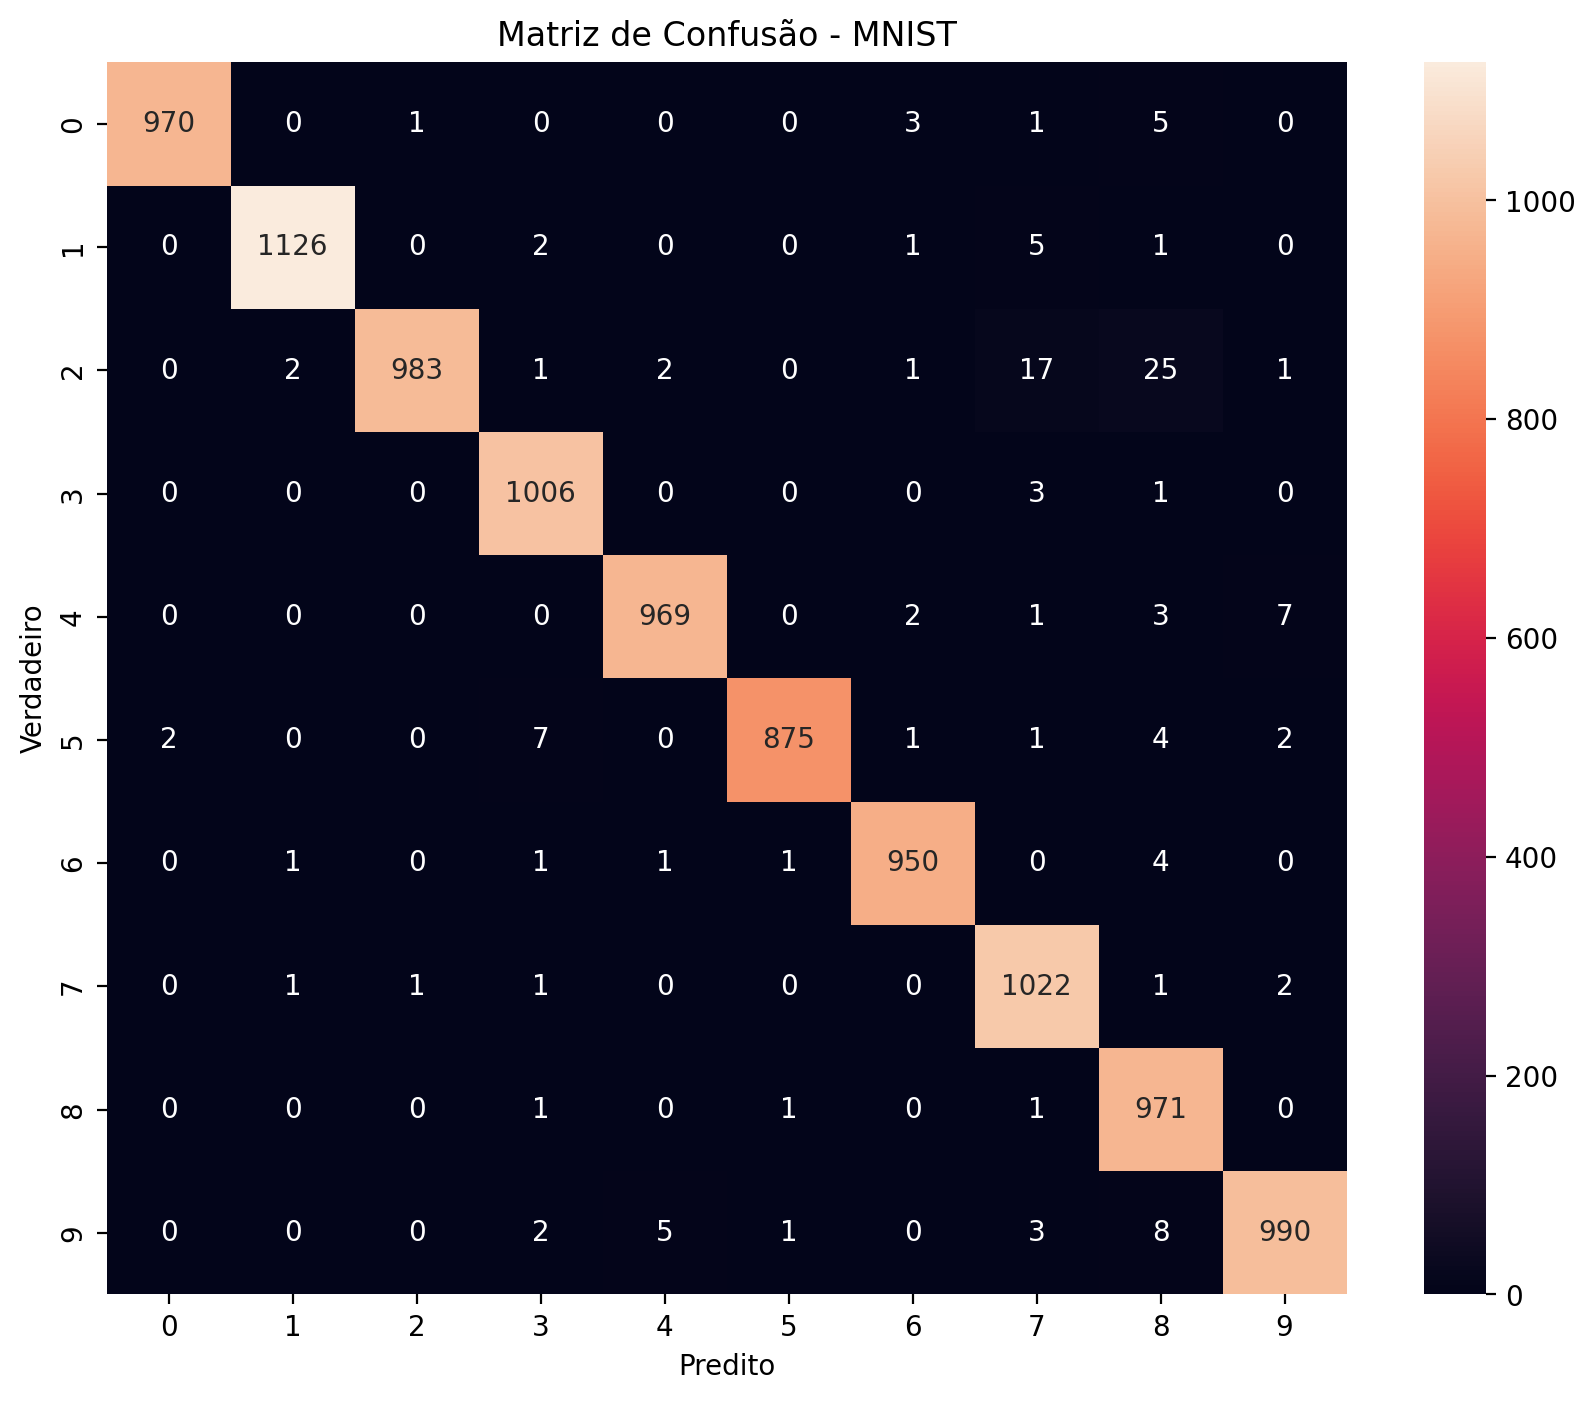

In [10]:
#resgata as listas com labels reais e previstas
y_true = minha_cnn.y_true
y_pred = minha_cnn.y_pred

cm = confusion_matrix(y_true, y_pred) #define a matriz de confusão

# plota a matrix de confusão
plt.figure(figsize=(10, 8), dpi=200)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - MNIST')
plt.savefig('Matriz de Confusão - MNIST')
plt.show()

# 😁 Conclusão
<div style="text-align: justify">A biblioteca Lightning mostrou-se bastante eficiente para lidar com os dados disponíveis. Especificamente, trabalhamos com um grande volume de dados e com baixa variabilidade entre os exemplos. Ainda assim, apenas duas épocas de treinamento com três filtros foram suficientes para alcançar uma acurácia superior a 98%, além de uma matriz de covariância que apresenta uma densidade de dados concentrada na diagonal principal, revelando a precisão do modelo. Dessa forma, consideramos essa ferramenta bastante poderosa para identificar padrões em imagens pequenas e de alto contraste, como as apresentadas no dataset MNIST. Neste projeto, não nos propusemos a encontrar padrões em imagens com contraste RGB, ou as quais os elementos a serem distinguidos possuem muitas semelhanças, de modo que a arquitetura utilizada, com apenas três filtros, mostrou-se suficiente para a tarefa proposta.

# 📚 Referências

$1.$ [**Nicola, Nicholas Di. “nicholas-dinicola/Lightning-Series"**](https://github.com/nicholas-dinicola/Lightning-Series). Acesso em 12 de abril de 2025. 

$2.$ [**GeeksforGeeks. “MNIST Dataset : Practical Applications Using Keras and PyTorch"**](https://www.geeksforgeeks.org/mnist-dataset/). Acesso em 12 de abril de 2025.

$3.$ **JAMES, Gareth; et al. An Introduction to Statistical Learning with Applications in Python.** 1. ed. Cham: Springer, 2023. p. 399–411.